# Synthetic catalog on a rate-and-state fault (RSQSim)

This notebook gives an example to reproduce the synthetic catalogs studied in:<br>
**Measuring and modeling the occupation probability to characterize the temporal statistics of seismic sequences**,<br>
submitted to *Geophysical Journal International*, by Eric Beaucé<br>


The numerical model is an implementation of RSQSim:<br>
Richards‐Dinger, Keith, and James H. Dieterich. "RSQSim earthquake simulator." Seismological Research Letters 83, no. 6 (2012): 983-990. DOI: [https://doi.org/10.1785/0220120105](https://doi.org/10.1785/0220120105)

In [16]:
%reload_ext autoreload
%autoreload 2

import sys
import os
import h5py as h5
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import shutil

from tqdm import tqdm
from time import time as give_time
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eqsimulator as eqsim
print(f"Using eqsimulator v:", eqsim.__version__)


Using eqsimulator v: 1.0.0-beta


In [17]:
# -------------------------------------------------
#         Output folder and file paths
OUTPUT_DIR = "output_rsqsim"
CLEAR_EXISTING_FOLDER = True
PROPERTY_FILE_PATH = os.path.join(OUTPUT_DIR, "fault_property.h5")
STATE_FILE_PATH = os.path.join(OUTPUT_DIR, "fault_mech_state.h5")
HISTORY_FILE_PATH = os.path.join(OUTPUT_DIR, "fault_history.h5")
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
elif CLEAR_EXISTING_FOLDER:
    shutil.rmtree(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR)

In [18]:
# ------------------------------------------
#           Simulation length
NUM_STEPS = 10000
NUM_STEPS_PER_CHECKPOINT = 1000
NUM_CHECKPOINTS = NUM_STEPS // NUM_STEPS_PER_CHECKPOINT
DISABLE_TQDM = True
SINGLE_PATCH_HISTORY_VAR_TO_SAVE = [
    "_event_timings",
    "_event_stress_drops",
    "_event_slips",
]


In [19]:
# ------------------------------------------
#            Fault patch geometry
STRIKE_WIDTH_M = 10.0
DIP_WIDTH_M = 10.0
Z_SRC_M = -7000.0
NUM_DEPTH_LAYERS = 10
NUM_PATCHES_PER_LINE = 10
NUM_PATCHES = NUM_DEPTH_LAYERS * NUM_PATCHES_PER_LINE
RIGHT_LATERAL_FAULTING = True
NORMAL_FAULTING = False
NUM_STEPS_INIT = 10 * NUM_PATCHES

In [20]:
# ------------------------------------------
#          Generate fault geometry
(
    fault_patch_coords,
    strike_angles,
    dip_angles,
    line_indexes,
    neighbors,
) = eqsim.faults_network_generator.complexity0(
    NUM_PATCHES_PER_LINE,
    STRIKE_WIDTH_M,
    DIP_WIDTH_M,
    -Z_SRC_M,
    n_depth_layers=NUM_DEPTH_LAYERS,
)

In [21]:
# --------------------------------------------
#           Fault properties
RIGHT_LATERAL_FAULTING = True
NORMAL_FAULTING = False
# elastic properties
V_S_MS = 3500.0  # [m/s]
RHO_KGM3 = 2700.0  # [kg/m3]
SHEAR_MODULUS_PA = V_S_MS**2 * RHO_KGM3  # [Pa], also called mu (Lame parameter) or G
POISSON_RATIO = 0.25  # [-]
LAMBDA = (
    2 * SHEAR_MODULUS_PA * POISSON_RATIO / (1 - 2 * POISSON_RATIO)
)  # [Pa] (Lame parameter)
ALPHA = (LAMBDA + SHEAR_MODULUS_PA) / (LAMBDA + 2 * SHEAR_MODULUS_PA)  # [-]

# frictional properties
NORMAL_STRESS_0 = 150.0 * 1.0e6  # from Dieterich 2010
A = 0.008  # from Dieterich 2010
B = 0.015  # from Dieterich 2010
D_C = 1.0e-5  # from Dieterich 2010
FRICTION_0 = 0.6  # from Dieterich 2010
SLIP_RATE_EQ_MS = 1.0 # from Dieterich 2010
SLIP_RATE_REF = 1.0e-6 # reference slip rate at which friction is FRICTION_0
THETA_0 = 1.0 * D_C / SLIP_RATE_EQ_MS
THETA_REF = D_C / SLIP_RATE_REF
A_REDUCTION_FACTOR = 0.1 # from Richards-Dinger and Dieterich 2012
V_V0_RATIO_FOR_UPDATE = 1.33 # update slip rate of creeping patches when it has diverged from the current slip speed by at least 33%
OVERSHOOT = 1.2 # from Richards-Dinger and Dieterich 2012

# ---------------------------------------
# these parameters were studied in Beaucé 2025
A_STABLE = 0.010 
B_STABLE = 0.0098
XI_STABLE = B_STABLE - A_STABLE
print(f"xi_stable is {XI_STABLE:.4f} (B - A)")
FRATION_STABLE_PATCHES = 0.2
# ---------------------------------------

xi_stable is -0.0002 (B - A)


In [22]:
# --------------------------------------------------------------------
#                  Forcing parameters
V_TECTONIC_NM_PER_SEC = 0.5
V_TECTONIC_M_PER_SEC = V_TECTONIC_NM_PER_SEC * 1.0e-9

In [23]:
# compile parameters into a dictionary

properties = {
    "mu_0": FRICTION_0,
    "a": A,
    "b": B,
    "Dc": D_C,
    "d_dot_star": SLIP_RATE_REF,
    "theta_star": THETA_REF,
    "sigma_0": NORMAL_STRESS_0,
    "d_dot_EQ": SLIP_RATE_EQ_MS,
    "beta": V_S_MS,
    "lame1": LAMBDA,
    "lame2": SHEAR_MODULUS_PA,
    "alpha": ALPHA,
    "L": STRIKE_WIDTH_M,
    "W": DIP_WIDTH_M,
    "right_lateral_faulting": RIGHT_LATERAL_FAULTING,
    "normal_faulting": False,
    "overshoot": OVERSHOOT,
    "record_history": True,
    "tectonic_slip_speed": V_TECTONIC_M_PER_SEC,
    "tectonic_stressing_rate": 0.0,
}

initial_mechanical_state = {
    "d_dot": 0.0,
    "theta": THETA_REF,
    "normal_stress": NORMAL_STRESS_0,
    "state": 0,
    "displacement": 0.0,
    "friction": 0.0,
    "initial_shear_stress": None,
}


In [24]:
# --------------------------------------------------------------------
#                Initialize model
z_min, z_max = fault_patch_coords[:, 2].min(), fault_patch_coords[:, 2].max()
x_min, x_max = fault_patch_coords[:, 0].min(), fault_patch_coords[:, 0].max()
print(z_min, z_max, x_min, x_max)

fault_patches = []
for i in range(NUM_PATCHES):
    # -------------------------------------
    # edges are slip-strengthening and some of the middle patches too
    if (
        fault_patch_coords[i, 0] == x_min
        or fault_patch_coords[i, 0] == x_max
        or fault_patch_coords[i, 2] == z_min
        or fault_patch_coords[i, 2] == z_max
    ) or np.random.random() < 0.30:
        _a = A_STABLE
        _b = B_STABLE
        _Dc = D_C
        _sigma_n = NORMAL_STRESS_0
    else:
        _a = A
        _b = B
        _Dc = D_C
        _sigma_n = NORMAL_STRESS_0
    initial_mechanical_state["normal_stress"] = _sigma_n
    properties["a"] = _a
    properties["b"] = _b
    properties["Dc"] = _Dc
    # -------------------------------------
    properties["x"] = fault_patch_coords[i, 0]
    properties["y"] = fault_patch_coords[i, 1]
    properties["z"] = fault_patch_coords[i, 2]
    properties["strike_angle"] = strike_angles[i]
    properties["dip_angle"] = dip_angles[i]

    fault_patch = eqsim.rate_and_state.RateStateFaultPatch(**properties)

    initial_mechanical_state["theta"] = THETA_0 * np.random.uniform(0.5, 1.5)
    initial_mechanical_state["initial_shear_stress"] = np.random.uniform(0.6, 0.95)
    fault_patch.initialize_mechanical_state(**initial_mechanical_state)
    fault_patch.initialize_history()
    fault_patches.append(fault_patch)

# %%
fault = eqsim.rate_and_state.RateStateFault(
    fault_patches,
    neighboring_patches=neighbors,
    verbose=False,
    a_reduction_factor=A_REDUCTION_FACTOR,
    V_V0_ratio_for_update=V_V0_RATIO_FOR_UPDATE,
)
for fp in fault.fault_patches:
    fp.V_V0_ratio_for_update = V_V0_RATIO_FOR_UPDATE
fault.initialize_mechanical_state()
# -------------------------------
# attach some useful attributes
fault.n_patches_per_line = NUM_PATCHES_PER_LINE
fault.n_lines = 1
fault.line_indexes = line_indexes

-7090.0 -7000.0 0.0 90.0
Patch 0 is stable.
Patch 1 is stable.
Patch 2 is stable.
Patch 3 is stable.
Patch 4 is stable.
Patch 5 is stable.
Patch 6 is stable.
Patch 7 is stable.
Patch 8 is stable.
Patch 9 is stable.
Patch 10 is stable.
Patch 12 is stable.
Patch 13 is stable.
Patch 15 is stable.
Patch 18 is stable.
Patch 19 is stable.
Patch 20 is stable.
Patch 23 is stable.
Patch 29 is stable.
Patch 30 is stable.
Patch 33 is stable.
Patch 39 is stable.
Patch 40 is stable.
Patch 43 is stable.
Patch 49 is stable.
Patch 50 is stable.
Patch 53 is stable.
Patch 55 is stable.
Patch 57 is stable.
Patch 59 is stable.
Patch 60 is stable.
Patch 65 is stable.
Patch 69 is stable.
Patch 70 is stable.
Patch 71 is stable.
Patch 72 is stable.
Patch 79 is stable.
Patch 80 is stable.
Patch 85 is stable.
Patch 89 is stable.
Patch 90 is stable.
Patch 91 is stable.
Patch 92 is stable.
Patch 93 is stable.
Patch 94 is stable.
Patch 95 is stable.
Patch 96 is stable.
Patch 97 is stable.
Patch 98 is stable.
Patch

In [25]:
# -----------------------------------------------------
#           save fault properties
fault.save_properties(PROPERTY_FILE_PATH)

In [26]:
# -------------------------------------------------------
#                Initialization
for i in range(NUM_STEPS_INIT):
    fault.evolve_next_patch()
fault.clean_history()


In [27]:
# -------------------------------------------------------
#                Simulation
t_last = give_time()
for i in range(NUM_CHECKPOINTS):
    t_current = give_time()
    print(f"--------- Checkpoint {i+1} / {NUM_CHECKPOINTS} -----------")
    print(f"         Time since last checkpoint: {t_current-t_last:.2f}sec   ")
    t_last = give_time()
    for j in tqdm(
        range(NUM_STEPS_PER_CHECKPOINT),
        desc=f"Steps to checkpoint {i}",
        disable=DISABLE_TQDM,
    ):
        fault.evolve_next_patch()

    tsave1 = give_time()
    fault.save_mechanical_state(STATE_FILE_PATH)
    fault.save_history(HISTORY_FILE_PATH, var=SINGLE_PATCH_HISTORY_VAR_TO_SAVE)
    fault.clean_history()
    tsave2 = give_time()
    print(f"         Saving and cleaning took {tsave2-tsave1:.2f}sec")
    print(f"         Simulated time is: {fault.time[-1]:.2f}")


--------- Checkpoint 1 / 10 -----------
         Time since last checkpoint: 0.00sec   
         Saving and cleaning took 2.54sec
         Simulated time is: 36535343.55
--------- Checkpoint 2 / 10 -----------
         Time since last checkpoint: 33.55sec   
         Saving and cleaning took 2.14sec
         Simulated time is: 40136362.43
--------- Checkpoint 3 / 10 -----------
         Time since last checkpoint: 32.59sec   
         Saving and cleaning took 2.16sec
         Simulated time is: 45709063.35
--------- Checkpoint 4 / 10 -----------
         Time since last checkpoint: 33.52sec   
         Saving and cleaning took 2.28sec
         Simulated time is: 51370095.91
--------- Checkpoint 5 / 10 -----------
         Time since last checkpoint: 34.03sec   
         Saving and cleaning took 2.20sec
         Simulated time is: 56451901.32
--------- Checkpoint 6 / 10 -----------
         Time since last checkpoint: 32.97sec   
         Saving and cleaning took 2.24sec
         Simula

## Test: Read from output files

In [28]:
for fp in fault.fault_patches:
    fp.initialize_history(
        path=HISTORY_FILE_PATH, gid=str(fp.fault_patch_id), readall=True, verbose=False
    )
event_history = eqsim.utils.get_event_history(fault)

## Plot

In [29]:
def format_to_grid(x, z, u):
    x = np.array(x)
    z = np.array(z)
    u = np.array(u)
    x_u = np.unique(x)
    z_u = np.unique(z)
    u_grid = np.zeros((len(z_u), len(x_u)))
    for i in range(len(x_u)):
        for j in range(len(z_u)):
            u_grid[j, i] = u[(x == x_u[i]) & (z == z_u[j])]
    return x_u, z_u, u_grid

In [30]:
# calcule slip per 100sec time bins
slip_history = pd.Series(
    index=event_history["event_time"].values,
    data=event_history["slip"].values,
)

slip_history = slip_history[
    slip_history.index > slip_history.index.max() * 0.1
]

slip_history = slip_history.groupby(
    pd.cut(slip_history.index,
            bins=np.arange(slip_history.index.min(), event_history["event_time"].values.max(), 100))
    ).sum()
slip_history

(24623059.064, 24623159.064]    0.0
(24623159.064, 24623259.064]    0.0
(24623259.064, 24623359.064]    0.0
(24623359.064, 24623459.064]    0.0
(24623459.064, 24623559.064]    0.0
                               ... 
(66694659.064, 66694759.064]    0.0
(66694759.064, 66694859.064]    0.0
(66694859.064, 66694959.064]    0.0
(66694959.064, 66695059.064]    0.0
(66695059.064, 66695159.064]    0.0
Length: 420721, dtype: float64

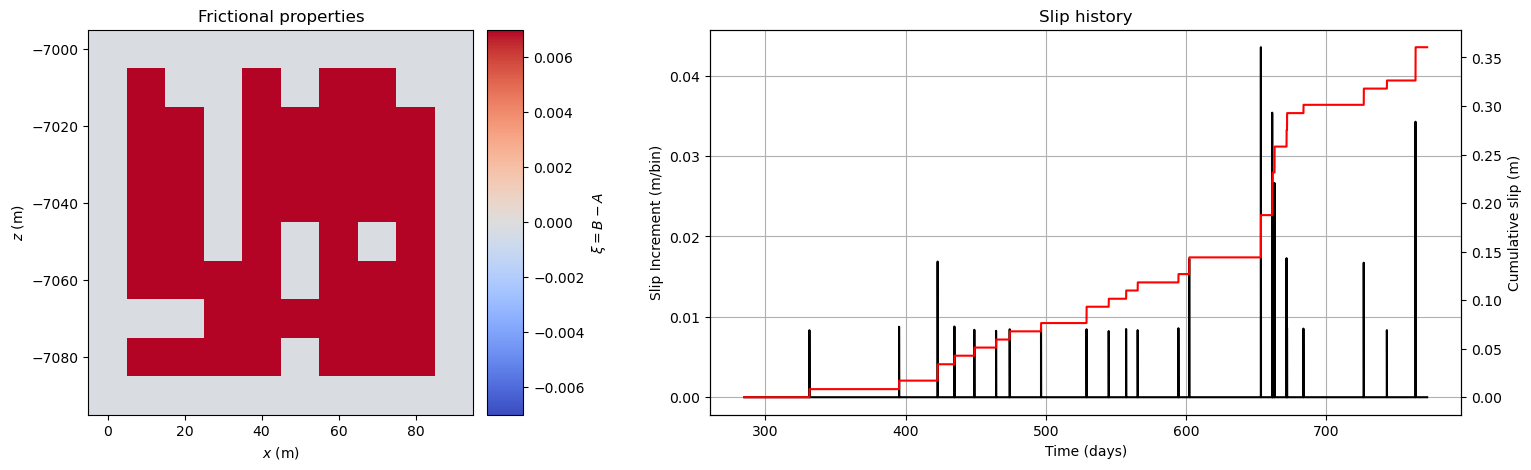

In [31]:
fig = plt.figure("slip_history", figsize=(18, 5))
gs = fig.add_gridspec(ncols=5)

scalar_map_xi = ScalarMappable(
    norm=Normalize(vmin=-0.007, vmax=+0.007), cmap=plt.cm.coolwarm
    )

# --------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :2])
x = [fp.x for fp in fault.fault_patches]
z = [fp.z for fp in fault.fault_patches]
xi = [fp.b - fp.a for fp in fault.fault_patches]

x_g, z_g, xi_g = format_to_grid(x, z, xi)
pc = ax1.pcolormesh(
    x_g,
    z_g,
    xi_g,
    shading="auto",
    cmap=scalar_map_xi.get_cmap(),
    norm=scalar_map_xi.norm,
    rasterized=True
)
ax1.set_xlabel(r"$x$ (m)")
ax1.set_ylabel(r"$z$ (m)")
ax1.set_xlim(min(x) - fault.fault_patches[0].L / 2., max(x) + fault.fault_patches[0].L / 2.)
ax1.set_ylim(min(z) - fault.fault_patches[0].W / 2., max(z) + fault.fault_patches[0].W / 2.)
ax1.set_aspect("equal")

pos = ax1.get_position()
cax = fig.add_axes([pos.x0 + pos.width - 0.02, pos.y0, 0.02, pos.height])
# plt.colorbar(sc, cax=cax, label=labels[i])
plt.colorbar(pc, cax=cax, label=r"$\xi = B - A$")
# plt.colorbar(pc, label=r"$\xi = B - A$")

ax1.set_title("Frictional properties")
# --------------------------------------------------------

# --------------------------------------------------------
_time = np.asarray([inter.left for inter in slip_history.index])
_time /= (24. * 3600.)

ax2 = fig.add_subplot(gs[0, 2:])
ax2b = ax2.twinx()
ax2.plot(_time, slip_history.values, color="k")
trend = _time / np.max(_time) * np.sum(slip_history.values)
ax2b.plot(_time, np.cumsum(slip_history.values), color="red")
ax2b.set_ylabel("Cumulative slip (m)")
ax2.set_xlabel("Time (days)")
ax2.set_ylabel("Slip Increment (m/bin)")
ax2.set_title("Slip history")
ax2.grid()
# --------------------------------------------------------

plt.subplots_adjust(wspace=2.0)


In [ ]:
# fig.savefig("example.png", dpi=250, bbox_inches="tight")